In [1]:
# --- Imports ---
import os, sys, time, math, pickle

import uproot
import numpy as np
import pandas as pd
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from scipy.special import betainc
from scipy.stats import norm

# --- Config imports ---
sys.path.append('/home/jlai/dark_photon/code_vr/config')
from plot_config import getWeight, zbi, sample_dict, getVarDict
from plot_var import variables, variables_mc, ntuple_names
from n_1_iteration_functions import (
    get_best_cut,
    calculate_significance,
    apply_cut_to_fb,
    apply_all_cuts,
    compute_total_significance,
    n_minus_1_optimizer,
)
from perf_sig_plot import plot_performance, plot_significance, plot_n_1

# --- Plot style ---
mpl.rcParams['figure.figsize'] = (14.0, 10.0)
mpl.rcParams['font.size'] = 20.0
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 14,
    "title": 20,
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],
    "xtick.labelsize": font_size["xticks"],
    "ytick.labelsize": font_size["yticks"],
    "legend.fontsize": font_size["legend"],
    "axes.titlesize": font_size["title"],
})


In [2]:
def test_none(fb, field="met_tst_et"):
    """Quick check for None values in a given branch."""
    mask = ak.is_none(fb[field])
    n_none = ak.sum(mask)
    print(f"[check] {field}: {n_none} None values")


def print_cut(ntuple_name, fb, label):
    """Print unweighted and (if available) weighted event counts."""
    print(f"{ntuple_name}: Unweighted events {label}: {len(fb)}")

    if "weights" in fb.fields:
        print(f"{ntuple_name}: Weighted events   {label}: {ak.sum(fb['weights'])}")
    else:
        print(f"{ntuple_name}: Weighted events   {label}: {ak.sum(getWeight(fb, ntuple_name))}")



In [3]:
tot = []
data = pd.DataFrame()

f_tmp = uproot.open("/data/fpiazza/ggHyyd/NtuplesWithBDTSkim/data24_y_nominal_bdt.root")["nominal"]

fb = f_tmp.arrays(variables, library="ak")

# Pre-cuts
fb = fb[ak.num(fb["ph_eta"]) > 0]  # for abs(ak.firsts(ph_eta)) in reweighting
fb = fb[fb["n_ph_baseline"] == 1]
fb = fb[fb["n_el_baseline"] == 0]

iso = (ak.firsts(fb["ph_topoetcone40"]) - 2450.0) / ak.firsts(fb["ph_pt"])
fb = fb[iso <= 0.022]

fb = fb[fb["n_bjet"] == 0]
fb = fb[ak.num(fb["ph_pt"]) > 0]
fb = fb[ak.firsts(fb["ph_pt"]) >= 50_000]     # ph_pt basic cut
fb = fb[fb["n_mu_baseline"] == 0]
fb = fb[fb["n_tau_baseline"] == 0]
fb = fb[fb["trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M"] == 1]
fb = fb[fb["met_tst_et"] >= 100_000]          # MET basic cut
fb = fb[fb["n_jet_central"] <= 3]

# mT
mt_tmp = (
    np.sqrt(
        2.0
        * fb["met_tst_et"]
        * ak.firsts(fb["ph_pt"])
        * (1.0 - np.cos(fb["met_tst_phi"] - ak.firsts(fb["ph_phi"])))
    )
    / 1000.0
)
fb = fb[mt_tmp > 80]

# met significance
metsig_tmp = fb["met_tst_sig"]
fb = fb[(metsig_tmp > 2) & (metsig_tmp < 4)]

# dphi_met_jetterm cleaning
dphi_met_jetterm_tmp = fb["dphi_met_jetterm"]
cond_bad = ak.fill_none(dphi_met_jetterm_tmp == -10, False)
fb["dphi_met_jetterm"] = ak.where(cond_bad, -999, dphi_met_jetterm_tmp)
fb = fb[fb["dphi_met_jetterm"] < 0.75]

# photon eta
ph_eta_tmp = np.abs(ak.firsts(fb["ph_eta"]))
fb = fb[ph_eta_tmp < 1.75]

# wrap Δφ into [0, π] and apply cut
fb["dphi_met_phterm"] = np.arccos(np.cos(fb["dphi_met_phterm"]))
fb = fb[fb["dphi_met_phterm"] > 0.5]

# rename BDT
fb["VertexBDTScore"] = fb["BDTScore"]

# unit weights for this sample
fb["weights"] = ak.ones_like(fb["met_tst_et"], highlevel=True) * 1.0

print_cut("data", fb, "after basic")

tot.append(fb)
del fb


data: Unweighted events after basic: 74005
data: Weighted events   after basic: 74005.0


In [4]:
ntuple_names = ['mc23e_Zgamma_y', 'mc23e_Wgamma_y', 'data24_y', 'data24_eprobe', 'mc23e_gammajet_direct_y']

for ntuple_name in ntuple_names:
    start_time = time.time()
    path = f"/data/fpiazza/ggHyyd/NtuplesWithBDTSkim/{ntuple_name}_nominal_bdt.root"
    f = uproot.open(path)["nominal"]

    # --- MC samples ---
    if ntuple_name.startswith("mc"):
        fb = f.arrays(variables + variables_mc, library="ak")
        print_cut(ntuple_name, fb, "before cut")

        fb = fb[ak.num(fb["ph_eta"]) > 0]
        fb = fb[fb["n_ph_baseline"] == 1]
        fb = fb[fb["n_el_baseline"] == 0]

        iso = (ak.firsts(fb["ph_topoetcone40"]) - 2450.0) / ak.firsts(fb["ph_pt"])
        fb = fb[iso <= 0.022]

    # --- data24_y: jet-faking ---
    elif ntuple_name == "data24_y":
        fb = f.arrays(variables, library="ak")
        print_cut(ntuple_name, fb, "before cut")

        fb = fb[ak.num(fb["ph_eta"]) > 0]
        iso = (ak.firsts(fb["ph_topoetcone40"]) - 2450.0) / ak.firsts(fb["ph_pt"])
        fb = fb[(iso > 0.1) & (iso < 0.4)]  # jet-faking region
        fb = fb[fb["n_ph_baseline"] == 1]
        fb = fb[fb["n_el_baseline"] == 0]

    # --- data24_eprobe: electron-faking ---
    elif ntuple_name == "data24_eprobe":
        fb = f.arrays(variables, library="ak")
        print_cut(ntuple_name, fb, "before cut")

        fb = fb[fb["trigger_single_el"] == 1]
        fb = fb[fb["n_el"] == 1]
        fb = fb[fb["n_ph_baseline"] == 0]

        # promote electron to "photon"
        fb["ph_pt"] = fb["el_pt"]
        fb["ph_eta"] = fb["el_eta"]
        fb["ph_phi"] = fb["el_phi"]
        fb["dphi_met_phterm"] = fb["dphi_met_eleterm"]

    # --- Common basic cuts for all samples ---
    fb = fb[fb["n_bjet"] == 0]
    fb = fb[ak.num(fb["ph_pt"]) > 0]
    fb = fb[ak.firsts(fb["ph_pt"]) >= 50_000]
    fb = fb[fb["n_mu_baseline"] == 0]
    fb = fb[fb["n_tau_baseline"] == 0]
    fb = fb[fb["trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M"] == 1]
    fb = fb[fb["met_tst_et"] >= 100_000]
    fb = fb[fb["n_jet_central"] <= 3]

    # mT
    mt_tmp = (
        np.sqrt(
            2.0
            * fb["met_tst_et"]
            * ak.firsts(fb["ph_pt"])
            * (1.0 - np.cos(fb["met_tst_phi"] - ak.firsts(fb["ph_phi"])))
        )
        / 1000.0
    )
    fb = fb[mt_tmp > 80]

    # metsig
    metsig_tmp = fb["met_tst_sig"]
    fb = fb[(metsig_tmp > 2) & (metsig_tmp < 4)]

    # dphi_met_jetterm cleaning + cut
    dphi_met_jetterm_tmp = fb["dphi_met_jetterm"]
    cond_bad = ak.fill_none(dphi_met_jetterm_tmp == -10, False)
    fb["dphi_met_jetterm"] = ak.where(cond_bad, -999, dphi_met_jetterm_tmp)
    fb = fb[fb["dphi_met_jetterm"] < 0.75]

    # photon eta
    ph_eta_tmp = np.abs(ak.firsts(fb["ph_eta"]))
    fb = fb[ph_eta_tmp < 1.75]

    # Δφ(MET,γ) wrapped + cut
    fb["dphi_met_phterm"] = np.arccos(np.cos(fb["dphi_met_phterm"]))
    fb = fb[fb["dphi_met_phterm"] > 0.5]

    # rename BDT
    fb["VertexBDTScore"] = fb["BDTScore"]

    fb['weights'] = getWeight(fb, ntuple_name)

    print_cut(ntuple_name, fb, "after basic")
    test_none(fb)

    print(f"Reading time for {ntuple_name}: {time.time() - start_time:.2f} s\n")

    tot.append(fb)
    del fb


mc23e_Zgamma_y: Unweighted events before cut: 8622736
mc23e_Zgamma_y: Weighted events   before cut: 66250.9765625
mc23e_Zgamma_y: Unweighted events after basic: 14184
mc23e_Zgamma_y: Weighted events   after basic: 212.6365509033203
[check] met_tst_et: 0 None values
Reading time for mc23e_Zgamma_y: 39.45 s

mc23e_Wgamma_y: Unweighted events before cut: 2162708
mc23e_Wgamma_y: Weighted events   before cut: 74767.5
mc23e_Wgamma_y: Unweighted events after basic: 6512
mc23e_Wgamma_y: Weighted events   after basic: 360.0600891113281
[check] met_tst_et: 0 None values
Reading time for mc23e_Wgamma_y: 9.54 s

data24_y: Unweighted events before cut: 7913491
data24_y: Weighted events   before cut: 12698042.221680505
data24_y: Unweighted events after basic: 23816
data24_y: Weighted events   after basic: 38548.634000003214
[check] met_tst_et: 0 None values
Reading time for data24_y: 30.31 s

data24_eprobe: Unweighted events before cut: 4452447
data24_eprobe: Weighted events   before cut: 168317.911

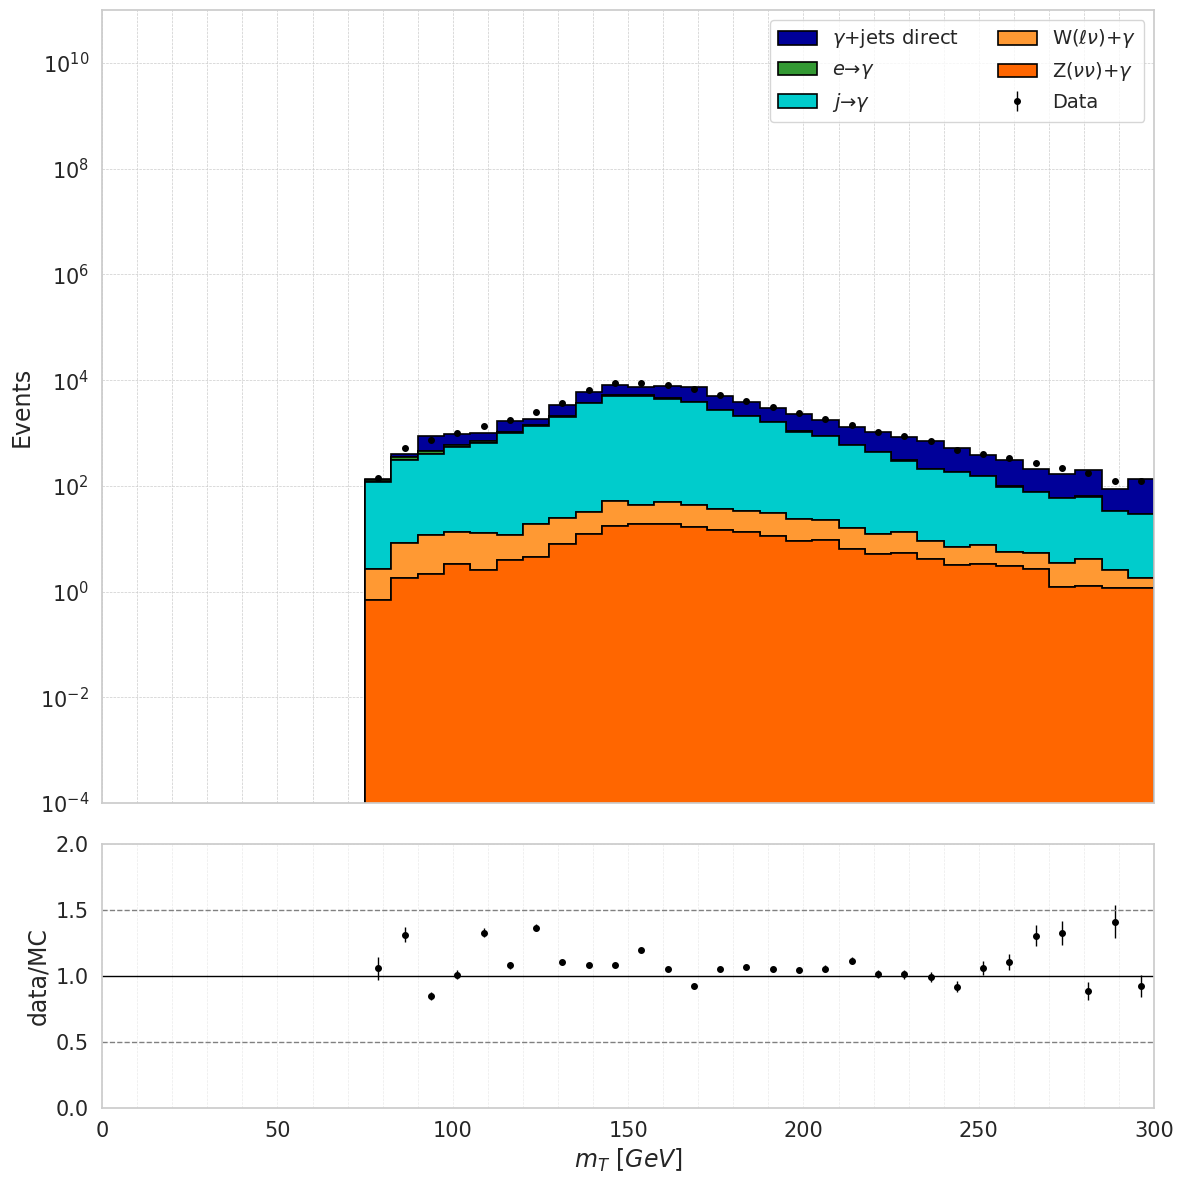

In [5]:
def plot_validation_performance(
    tot2,
    ntuple_names,
    sample_dict,
    getVarDict,
    mt_val_dir,
    cut_name,
    data_name="data",        # name of the data sample in ntuple_names & sample_dict
):
    """
    Make ATLAS-style validation plots:
      - top: stacked backgrounds + data as black markers
      - bottom: data/MC ratio
    """

    # variable configuration (bins, titles, etc.)
    var_config = getVarDict(tot2[0], "Zgamma", var_name="mt")

    for var in var_config:
        # -----------------------------
        # Collect hist inputs
        # -----------------------------
        bg_values   = []
        bg_weights  = []
        bg_colors   = []
        bg_labels   = []

        data_values  = []
        data_weights = []
        data_color   = sample_dict[data_name]["color"]
        data_label   = sample_dict[data_name]["legend"]

        for j, process in enumerate(ntuple_names):
            fb = tot2[j]
            cfg = getVarDict(fb, process, var_name=var)

            x       = cfg[var]["var"]
            bins    = np.linspace(0, 300, 40+1)
            weights = fb["weights"]

            info    = sample_dict[process]
            color   = info["color"]
            legend  = info["legend"]

            if process == data_name:
                data_values.append(x)
                data_weights.append(weights)
            else:
                bg_values.append(x)
                bg_weights.append(weights)
                bg_colors.append(color)
                bg_labels.append(legend)

        # flatten lists into single arrays
        data_all         = np.concatenate(data_values)  if len(data_values) > 0 else np.array([])
        data_weights_all = np.concatenate(data_weights) if len(data_weights) > 0 else np.array([])

        bg_all           = np.concatenate(bg_values)    if len(bg_values) > 0 else np.array([])
        bg_weights_all   = np.concatenate(bg_weights)   if len(bg_weights) > 0 else np.array([])

        # -----------------------------
        # Top panel: stacked MC + data
        # -----------------------------
        fig, (ax_top, ax_bot) = plt.subplots(
            2, 1,
            figsize=(12, 12),
            gridspec_kw={"height_ratios": [3, 1]},
            sharex=True
        )

        # stacked backgrounds
        ax_top.hist(
            bg_values,
            bins=bins,
            weights=bg_weights,
            color=bg_colors,
            label=bg_labels,
            stacked=True,
            histtype="stepfilled",
            linewidth=1.2,
            edgecolor="black",
        )

               # histograms for data & total MC (for errors / ratio)
        data_counts, bin_edges = np.histogram(data_all, bins=bins, weights=data_weights_all)
        data_w2, _             = np.histogram(data_all, bins=bins, weights=data_weights_all**2)

        mc_counts, _ = np.histogram(bg_all, bins=bins, weights=bg_weights_all)
        mc_w2, _     = np.histogram(bg_all, bins=bins, weights=bg_weights_all**2)

        # --- make sure these are *NumPy* arrays, not Awkward ---
        data_counts = np.asarray(data_counts, dtype=float)
        data_w2     = np.asarray(data_w2,     dtype=float)
        mc_counts   = np.asarray(mc_counts,   dtype=float)
        mc_w2       = np.asarray(mc_w2,       dtype=float)

        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        data_err    = np.sqrt(data_w2)

        # draw data as black markers with error bars (top panel)
        nonzero_mask = data_counts > 0
        ax_top.errorbar(
            bin_centers[nonzero_mask],
            data_counts[nonzero_mask],
            yerr=data_err[nonzero_mask],
            fmt="o",
            color=data_color,
            label=data_label,
            markersize=4,
            linewidth=1,
        )
        ax_top.set_yscale("log")
        ax_top.set_ylim(0.0001, 1e11)
        ax_top.set_xlim(bins[0], bins[-1])
        ax_top.minorticks_on()
        ax_top.grid(True, which="both", linestyle="--", linewidth=0.5)
        ax_top.set_ylabel("Events")
        ax_top.legend(ncol=2)

        # -----------------------------
        # Bottom panel: data / MC
        # -----------------------------
        # initialize as pure NumPy arrays
        ratio     = np.full(mc_counts.shape, np.nan, dtype=float)
        ratio_err = np.zeros(mc_counts.shape, dtype=float)

        mc_nonzero = mc_counts > 0
        ratio[mc_nonzero]     = data_counts[mc_nonzero] / mc_counts[mc_nonzero]
        ratio_err[mc_nonzero] = data_err[mc_nonzero]   / mc_counts[mc_nonzero]

        ax_bot.errorbar(
            bin_centers[mc_nonzero],
            ratio[mc_nonzero],
            yerr=ratio_err[mc_nonzero],
            fmt="o",
            color="black",
            markersize=4,
            linewidth=1,
        )


        ax_bot.axhline(1.0, color="black", linewidth=1)
        ax_bot.axhline(0.5, color="gray", linestyle="--", linewidth=1)
        ax_bot.axhline(1.5, color="gray", linestyle="--", linewidth=1)

        ax_bot.set_ylabel("data/MC")
        ax_bot.set_xlabel(var_config[var]["title"])   # should be "m_T [GeV]" for mt
        ax_bot.set_xlim(bins[0], bins[-1])
        ax_bot.set_ylim(0.0, 2.0)
        ax_bot.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.4)

        plt.tight_layout()
        # outpath = f"/home/jlai/dark_photon/main/{mt_val_dir}/{cut_name}cut/{var}.png"
        # plt.savefig(outpath)
        # plt.close()
        # print(f"Saved validation plot to {outpath}")
        plt.show()

ntuple_names = ["data", "Zgamma", "Wgamma", "data_y", "data_eprobe", "gammajet_direct"]

plot_validation_performance(
    tot,               # list of fb arrays in that order
    ntuple_names,
    sample_dict,
    getVarDict,
    mt_val_dir="mt100_140",
    cut_name="basic",
    data_name="data",          # tot[0] is the SR data
)


In [3]:
def compute_total_significance(tot2, ntuple_names, signal_name, getVarDict):
    signal_sum = 0
    bkg_sum = 0
    for i in range(len(ntuple_names)):
        fb = tot2[i]
        process = ntuple_names[i]
        weights = fb['weights']
        if process == signal_name:
            signal_sum += ak.sum(weights)
        else:
            bkg_sum += ak.sum(weights)
    return signal_sum / np.sqrt(bkg_sum) if bkg_sum > 0 else 0

sig_tmp = compute_total_significance(tot, ntuple_names, signal_name, getVarDict)
print("significance: ", sig_tmp)

significance:  1.6875358436074388
